February: Real cases - Original depth and depth anomaly.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
colour_list = ["#c8274c","#f25546","#F06543","#e96e33","#f0b038","#FFE74C",
               "#69b944","#72b286","#69b0bc","#619ee4","#4b5bbb"][::-1]
from matplotlib.colors import LinearSegmentedColormap
cmap_iam = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
cmap_iam.set_bad('wheat')

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [4]:
def get_vars(dirname, dep_ind):
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    time_ind = 24*13
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][:time_ind, dep_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:time_ind, 0, 0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, dep_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, sozotaux, deptht, tmask

In [5]:
def get_1day_avg(sal, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    sal_day = np.mean(sal[day, ...], axis=0)
    return sal_day

In [6]:
def get_daily_vosaline(vosaline, tmask):
    
    # get daily salinity averages from hourly results
    vosaline_daily0 = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)
    for i in range(vosaline_daily0.shape[0]):
        day_start, day_end = i, i+1
        vosaline_daily0[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

    tmask_new = np.tile(tmask[0, :, :, :], (vosaline_daily0.shape[0], 1, 1))
    vosaline_daily = np.ma.array(vosaline_daily0, mask=1 - tmask_new)

    print(type(vosaline_daily0), vosaline_daily0.shape, tmask_new.shape, vosaline_daily.shape, type(vosaline_daily))
    
    return vosaline_daily, tmask_new

In [7]:
def get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile):
    
    # trace back the deptht_ind where this_vosaline occured the vosaline_ref     
    deptht_ind_daily = np.full_like(vosaline_daily, np.nan, dtype=np.int)
    for t in range(deptht_ind_daily.shape[-3]):
        print(t)
        for y in range(deptht_ind_daily.shape[-2]):
            for x in range(deptht_ind_daily.shape[-1]):
                this_vosaline = vosaline_daily[t, y, x]
                deptht_ind_daily[t, y, x] = min(range(len(vosaline_ref_profile)), key=lambda i: abs(vosaline_ref_profile[i]-this_vosaline))

    print(deptht_ind_daily.shape, type(deptht_ind_daily))

    return deptht_ind_daily

In [8]:
def get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new):

    # get deptht for deptht_ind of origin
    deptht_m_daily0 = deptht[deptht_ind_daily]
    deptht_m_daily = np.ma.array(deptht_m_daily0, mask=1 - tmask_new)

    print(deptht_m_daily.shape, type(deptht_m_daily))
    
    return deptht_m_daily

In [19]:
def pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel):
    
    fig, axes = plt.subplots(3, 3, figsize = (20, 20))
    for ax, n in zip(axes.flatten(), np.arange(9)):  
        p = ax.pcolormesh(plot_array[n, :, :], cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, plot_array.shape[-1]])
        ax.set_ylim([0, plot_array.shape[-2]])
        ax.set_title('Day ' + str(n+1), fontsize=20)
        ax.axvline(110, c='k')
        if n == 0:
            cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
            cbar.set_label(cblabel, fontsize=18, rotation=0, labelpad=2.5)
            cbar.ax.tick_params(labelsize=13)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
        else:
            pass
    fig.tight_layout(w_pad=1.2, h_pad=0.01)
    fig.suptitle(title + ' [Depth = '+str(int(deptht[dep_ind]))+' m]', fontsize=25)
    plt.subplots_adjust(top=0.95)

    return fig

# Load salinity reference profile

In [11]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

# Depth index

In [12]:
dep_ind = 9

# Real_half

In [31]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_half/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [32]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (13, 272, 182) (13, 272, 182) (13, 272, 182) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
12
(13, 272, 182) <class 'numpy.ma.core.MaskedArray'>
(13, 272, 182) <class 'numpy.ma.core.MaskedArray'>


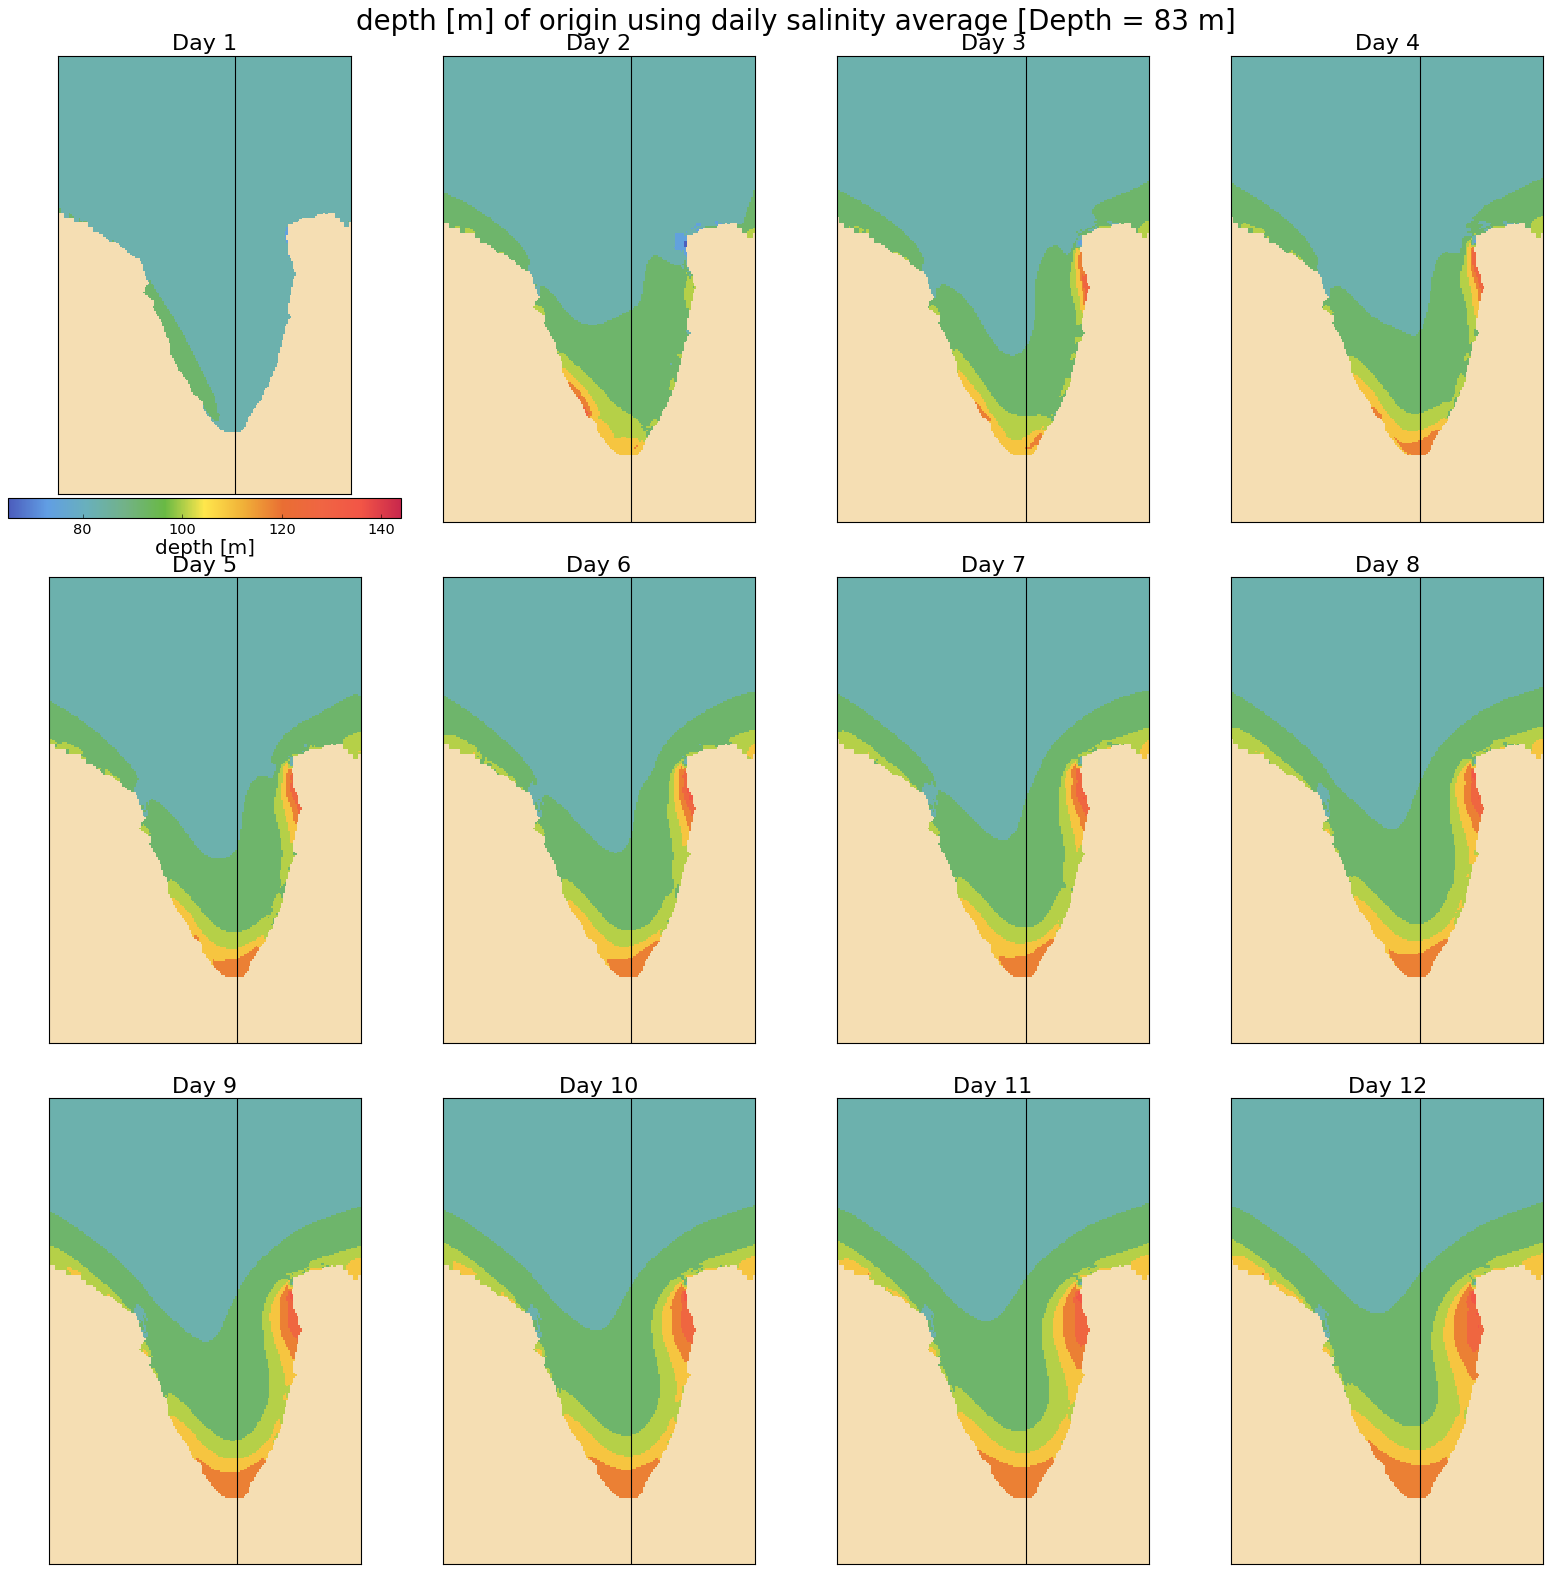

In [33]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, None
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

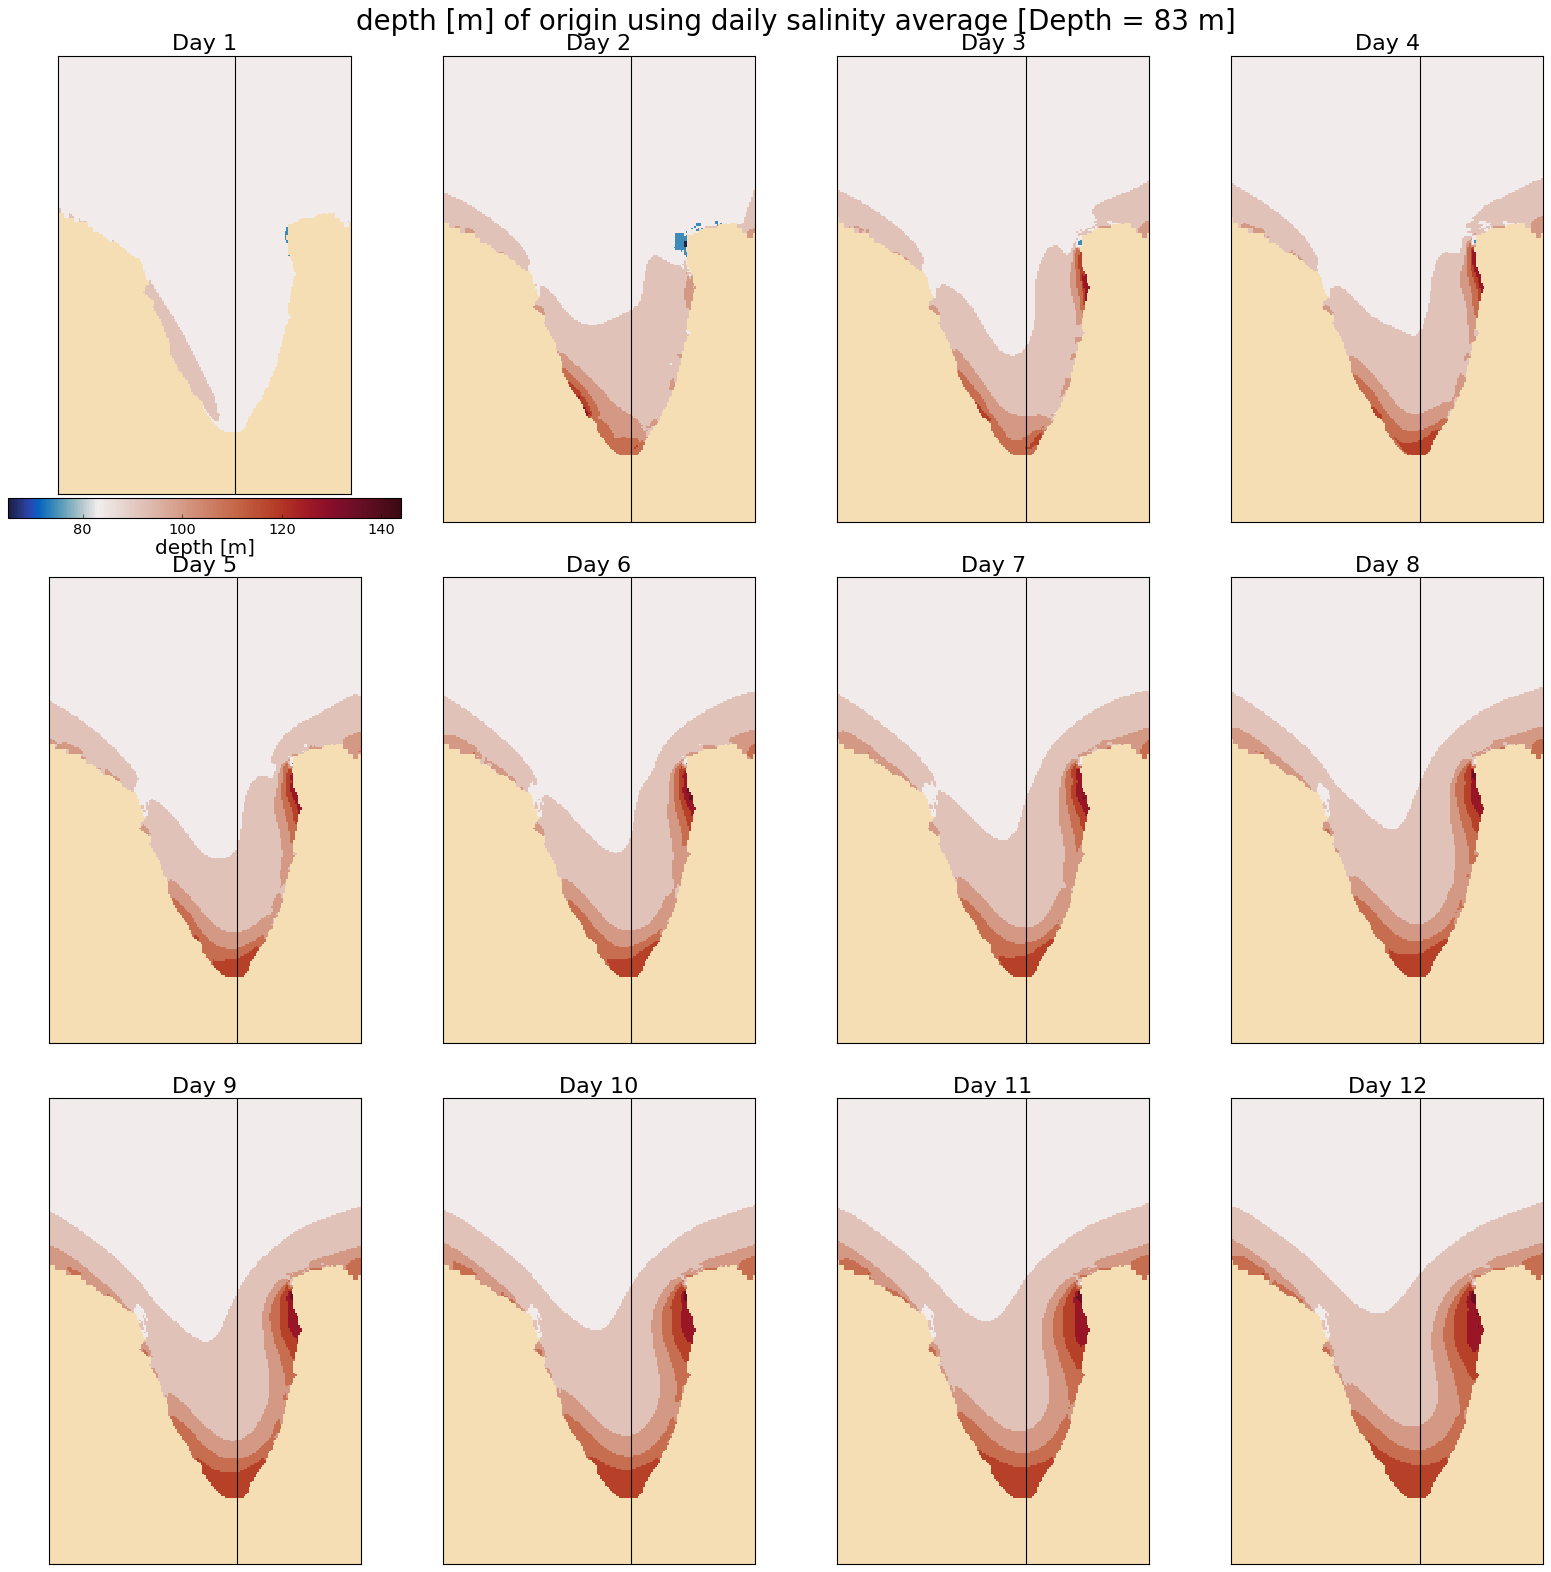

In [34]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

In [35]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()))

day 0, ind 10, dep 91.875
day 1, ind 14, dep 126.875
day 2, ind 14, dep 126.875
day 3, ind 14, dep 126.875
day 4, ind 14, dep 126.875
day 5, ind 15, dep 135.625
day 6, ind 15, dep 135.625
day 7, ind 15, dep 135.625
day 8, ind 15, dep 135.625
day 9, ind 15, dep 135.625
day 10, ind 15, dep 135.625
day 11, ind 15, dep 135.625
day 12, ind 16, dep 144.375


# Real_base

In [36]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_base/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [37]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (13, 272, 182) (13, 272, 182) (13, 272, 182) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
12
(13, 272, 182) <class 'numpy.ma.core.MaskedArray'>
(13, 272, 182) <class 'numpy.ma.core.MaskedArray'>


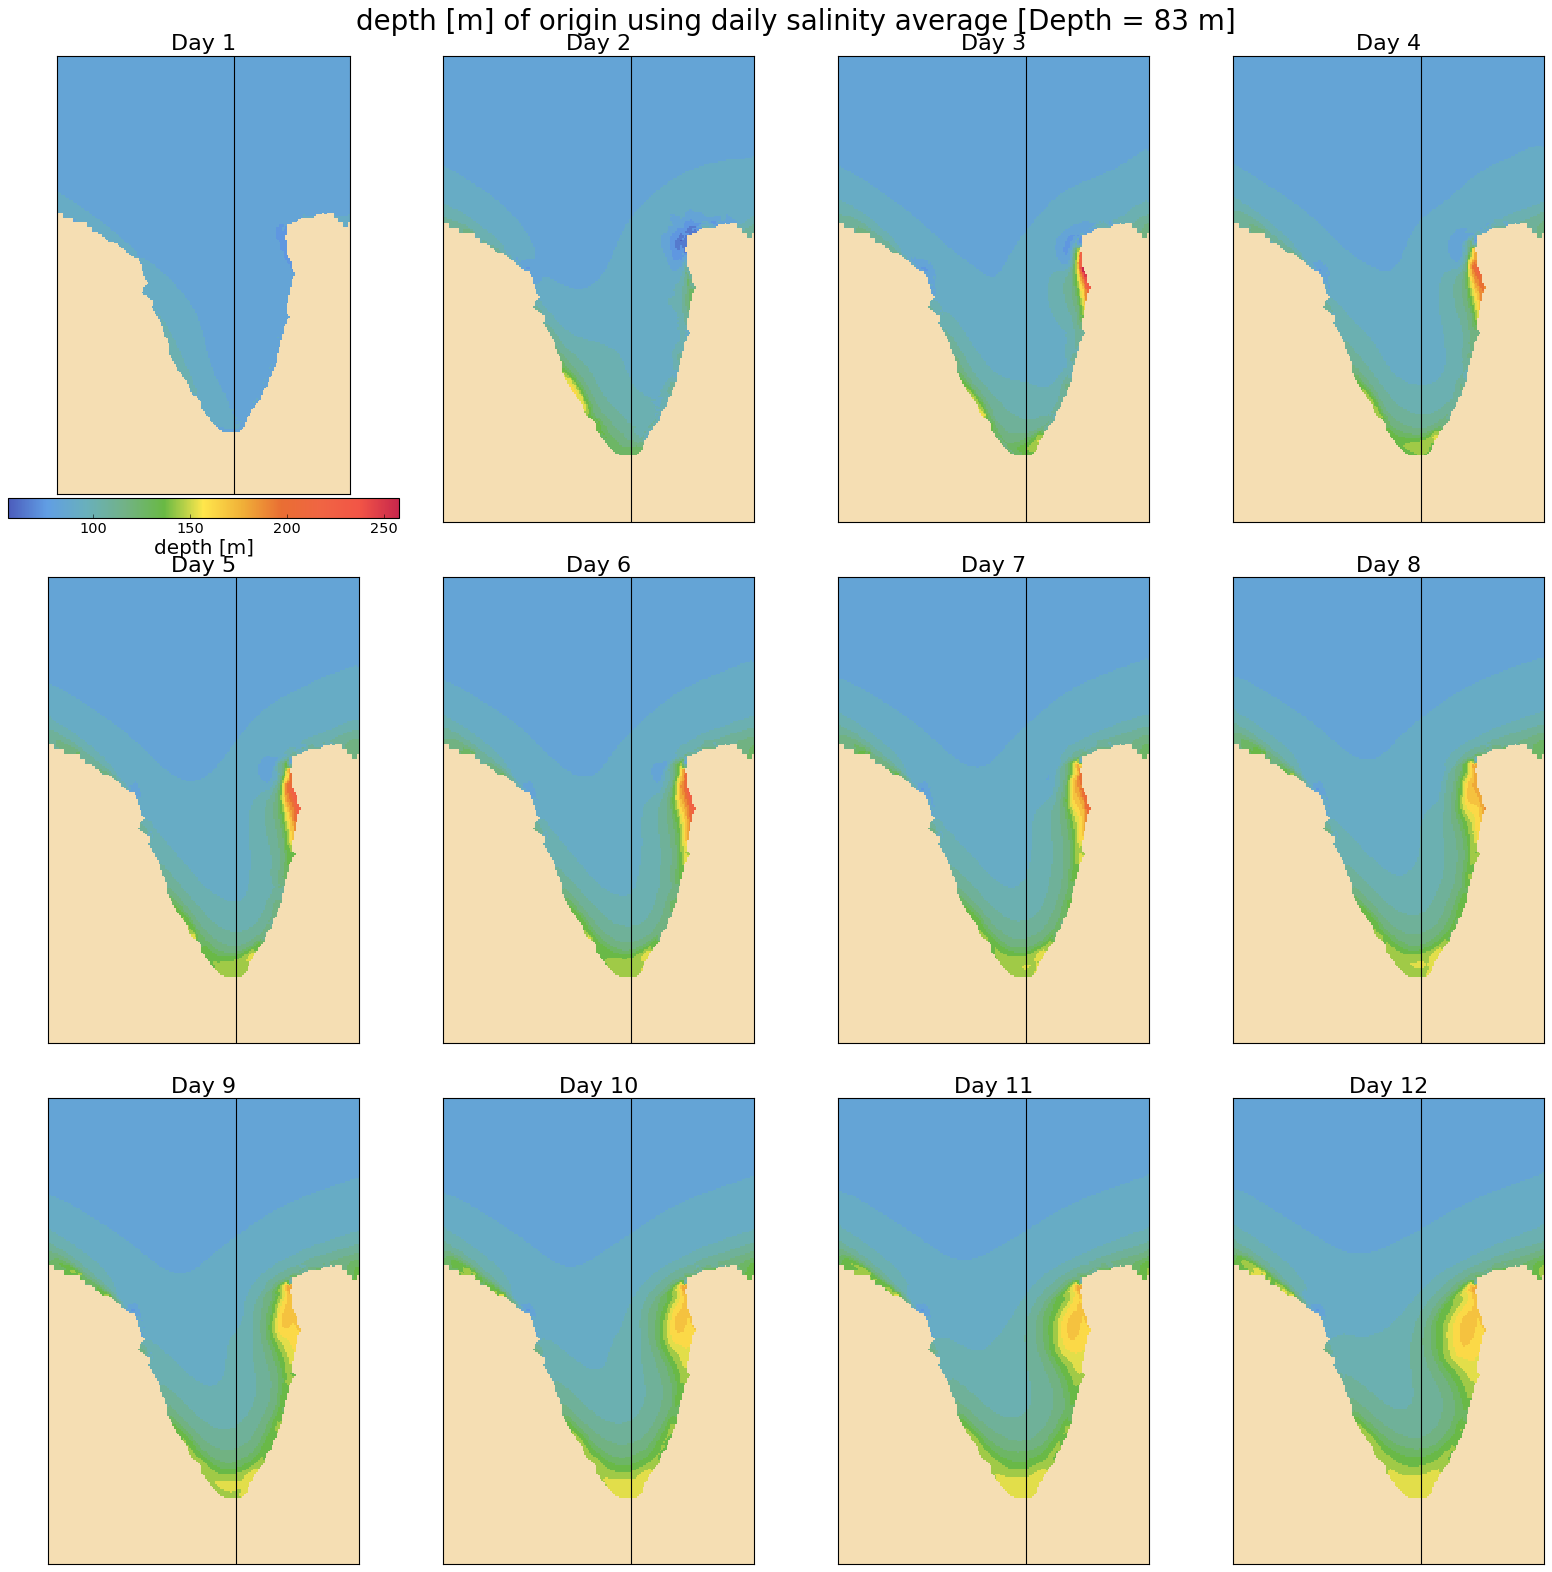

In [38]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, None
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

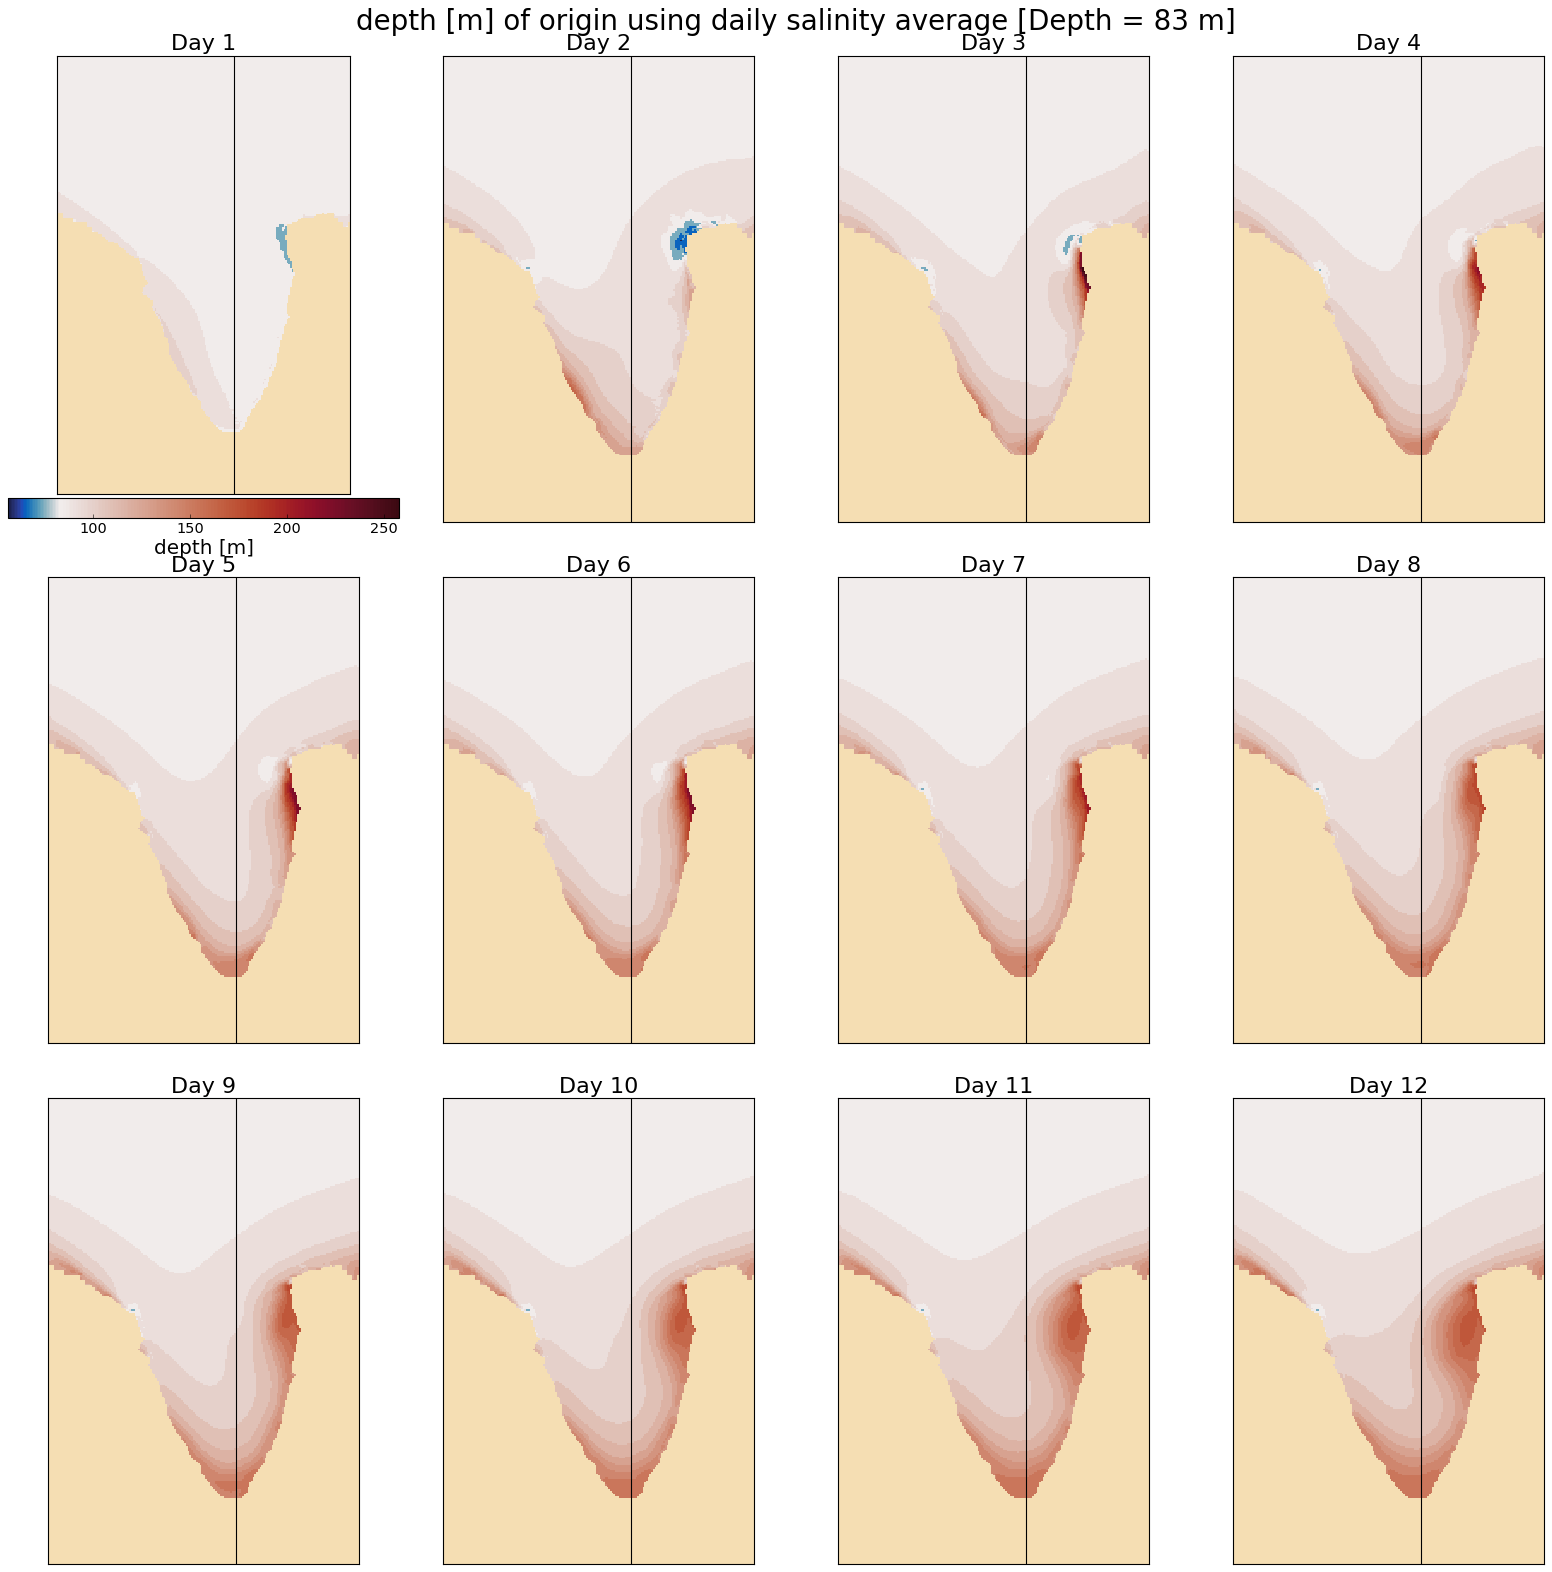

In [39]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

In [40]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()))

day 0, ind 11, dep 100.625
day 1, ind 18, dep 161.875
day 2, ind 29, dep 258.125
day 3, ind 24, dep 214.375
day 4, ind 25, dep 223.125
day 5, ind 25, dep 223.125
day 6, ind 23, dep 205.625
day 7, ind 21, dep 188.125
day 8, ind 20, dep 179.375
day 9, ind 20, dep 179.375
day 10, ind 20, dep 179.375
day 11, ind 20, dep 179.375
day 12, ind 21, dep 188.125


# Real Double

In [13]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_double/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [14]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (10, 272, 182) (10, 272, 182) (10, 272, 182) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
(10, 272, 182) <class 'numpy.ma.core.MaskedArray'>
(10, 272, 182) <class 'numpy.ma.core.MaskedArray'>


In [60]:
def pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel):
    
    fig, axes = plt.subplots(2, 5, figsize = (20, 15))
    for ax, n in zip(axes.flatten(), np.arange(10)):  
        p = ax.pcolormesh(plot_array[n, :, :], cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, plot_array.shape[-1]])
        ax.set_ylim([0, plot_array.shape[-2]])
        ax.set_title('Day ' + str(n+1), fontsize=20)
        #ax.axvline(110, c='k')
        cbar = fig.colorbar(p, ax=ax, fraction=0.03, orientation='horizontal', pad=0.009)
        cbar.set_label(cblabel, fontsize=18, rotation=0, labelpad=2.5)
        cbar.ax.tick_params(labelsize=13)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()

    fig.tight_layout(w_pad=1.2, h_pad=0.02)
    fig.tight_layout(rect=[0, 0, 1, 0.99])
    fig.suptitle(title + ' [Depth = '+str(int(deptht[dep_ind]))+' m]', fontsize=25)
    #plt.subplots_adjust(top=0.95)

    return fig

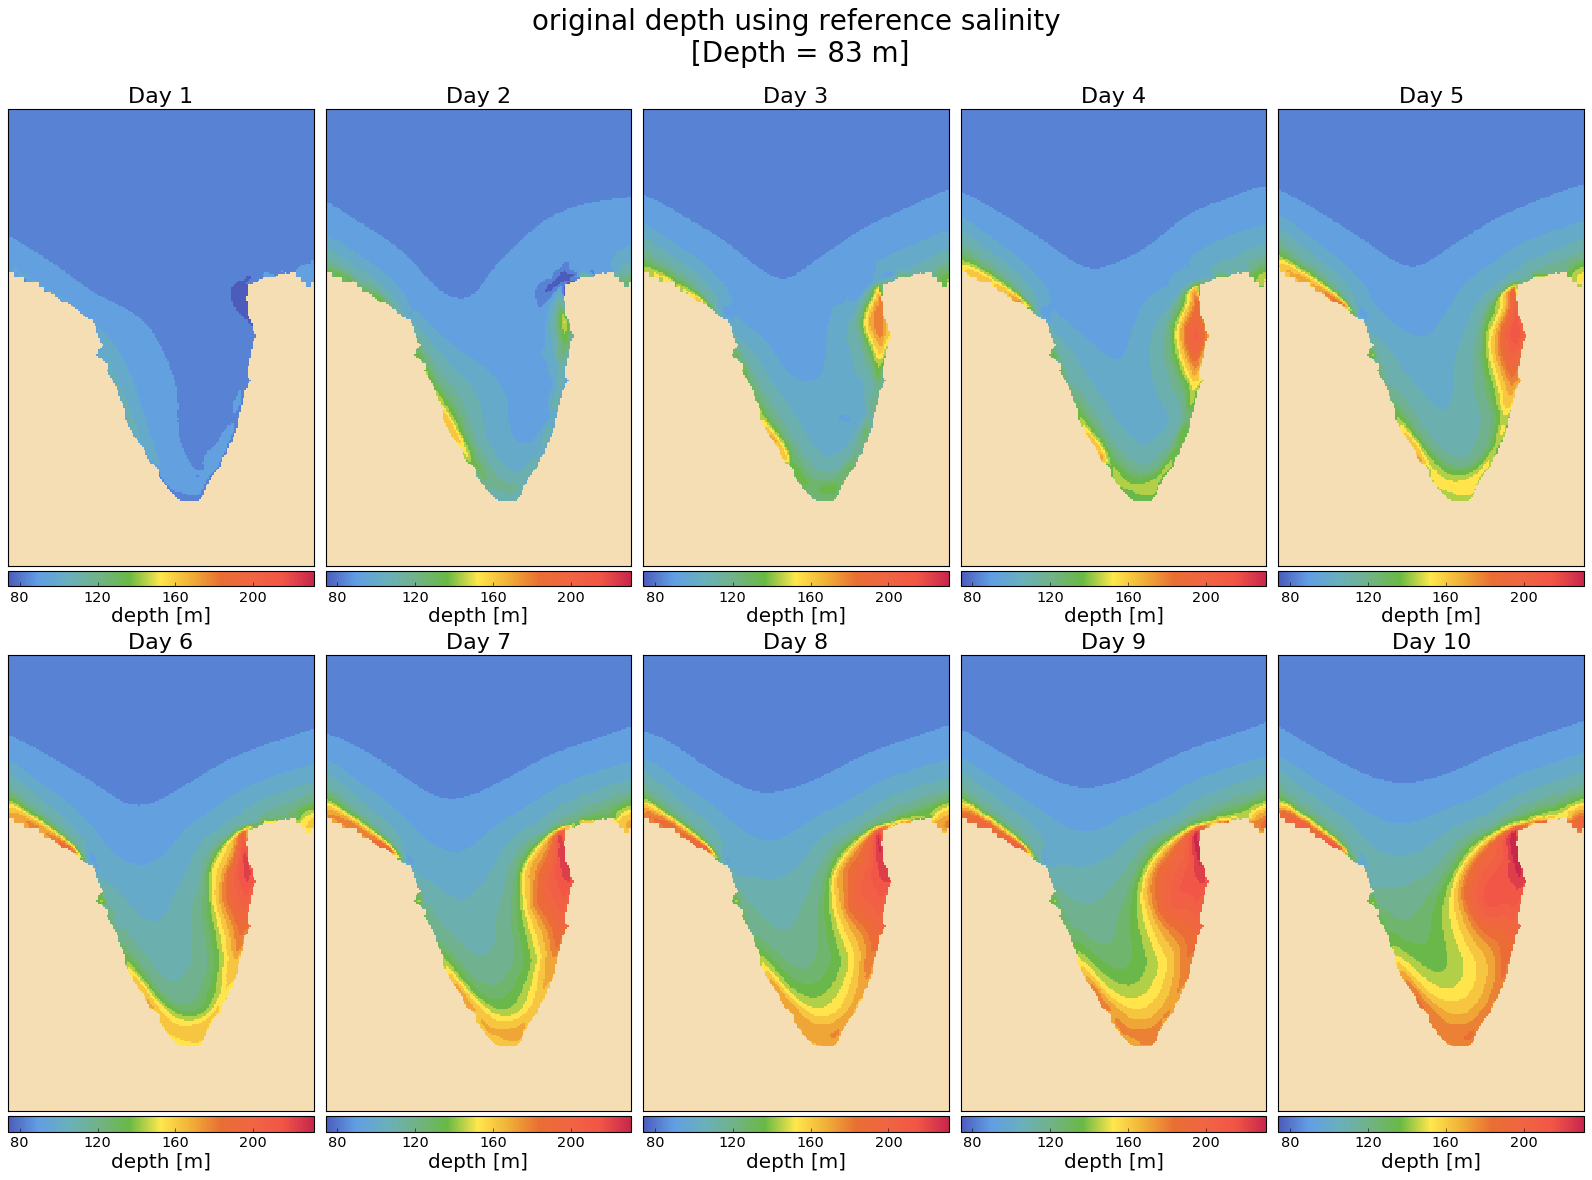

In [71]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, None
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'original depth using reference salinity\n', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)
fig.savefig('../observations/ud_dep83_A.png', dpi=100)

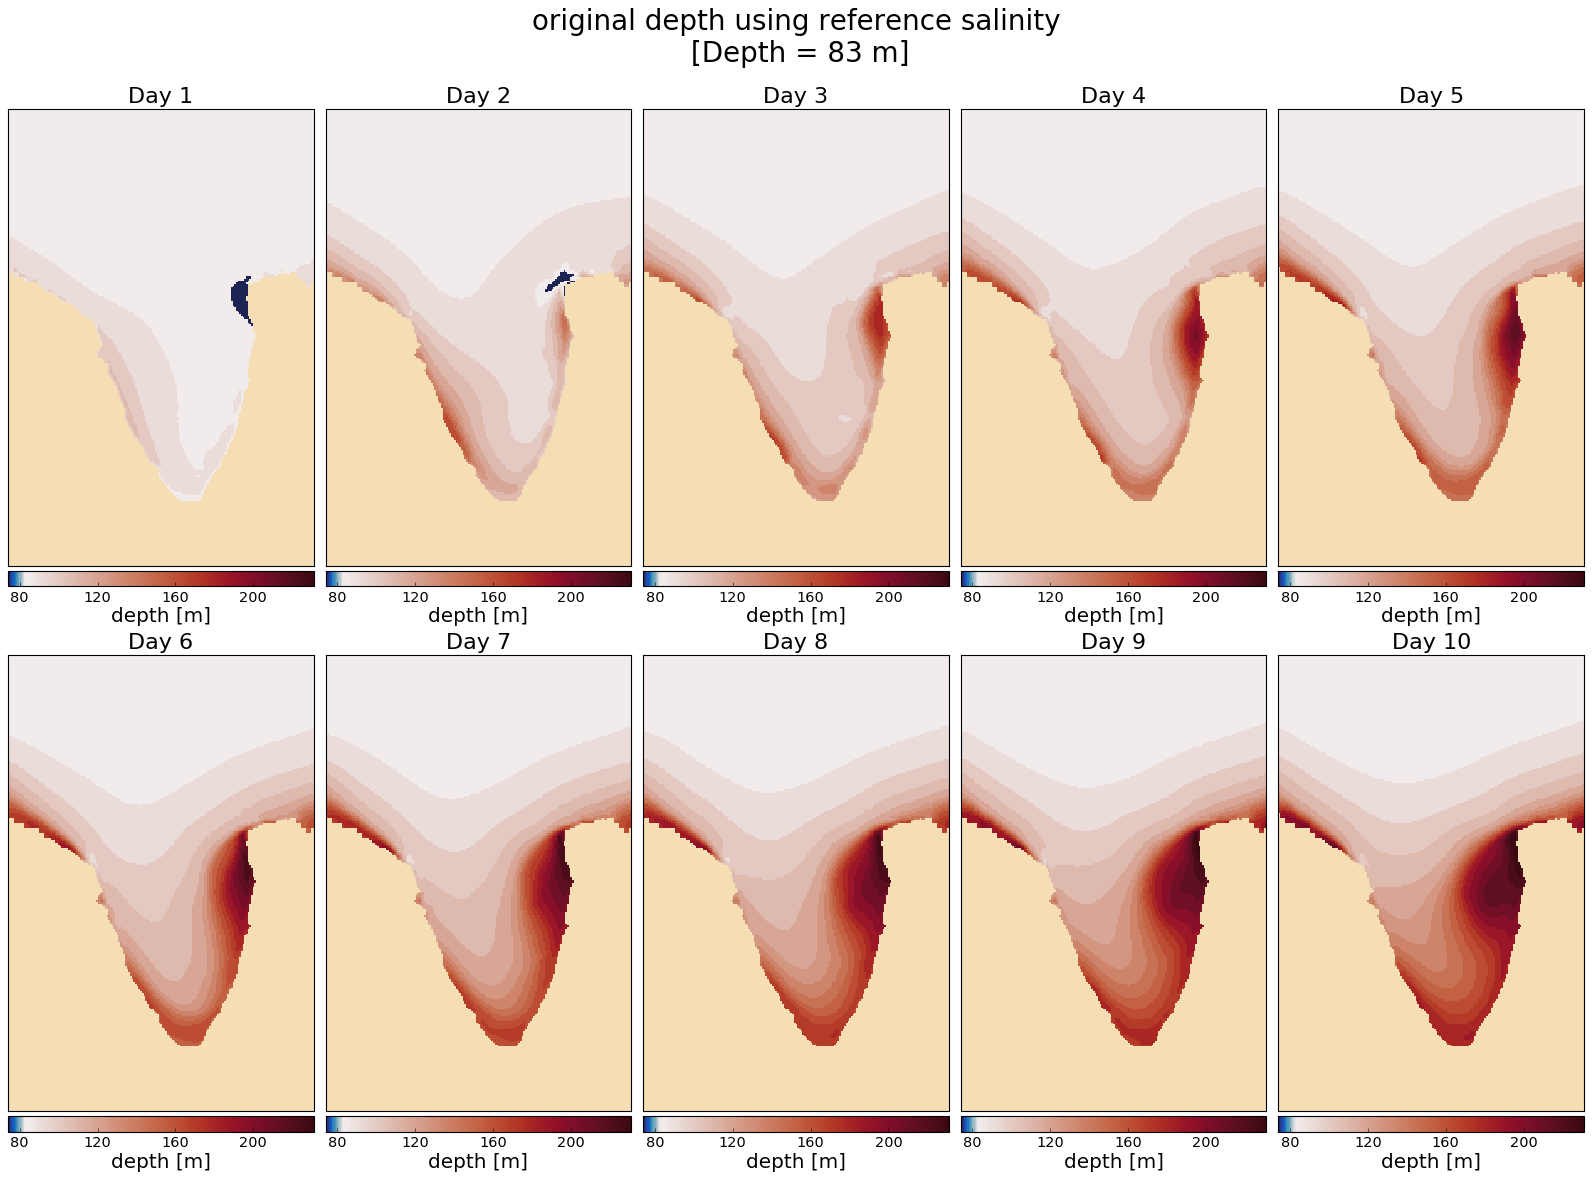

In [72]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'original depth using reference salinity\n', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)
fig.savefig('../observations/ud_dep83_B.png', dpi=100)

In [18]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()))

day 0, ind 12, dep 109.375
day 1, ind 18, dep 161.875
day 2, ind 20, dep 179.375
day 3, ind 23, dep 205.625
day 4, ind 24, dep 214.375
day 5, ind 25, dep 223.125
day 6, ind 25, dep 223.125
day 7, ind 26, dep 231.875
day 8, ind 26, dep 231.875
day 9, ind 26, dep 231.875
